In [ ]:
setwd("/Users/rebecca/sudmant/analyses/myotis/analysis/exploratory/species_individual_peaks")

library(GSA)
library(dplyr)
library(scales)
library(qvalue)
library(ggplot2)
library(data.table)

source("/Users/rebecca/sudmant/analyses/myotis/code/fisher_test.R")

myo_meta <- read.csv("/Users/rebecca/sudmant/analyses/myotis/data/myotis_meta.csv")

## Get differential peak status between species in orthologous genes

peak_ortho_files <- list.files(path = "results/data", 
                               pattern = "genes_5000.*orthologs",
                               full.names = TRUE)

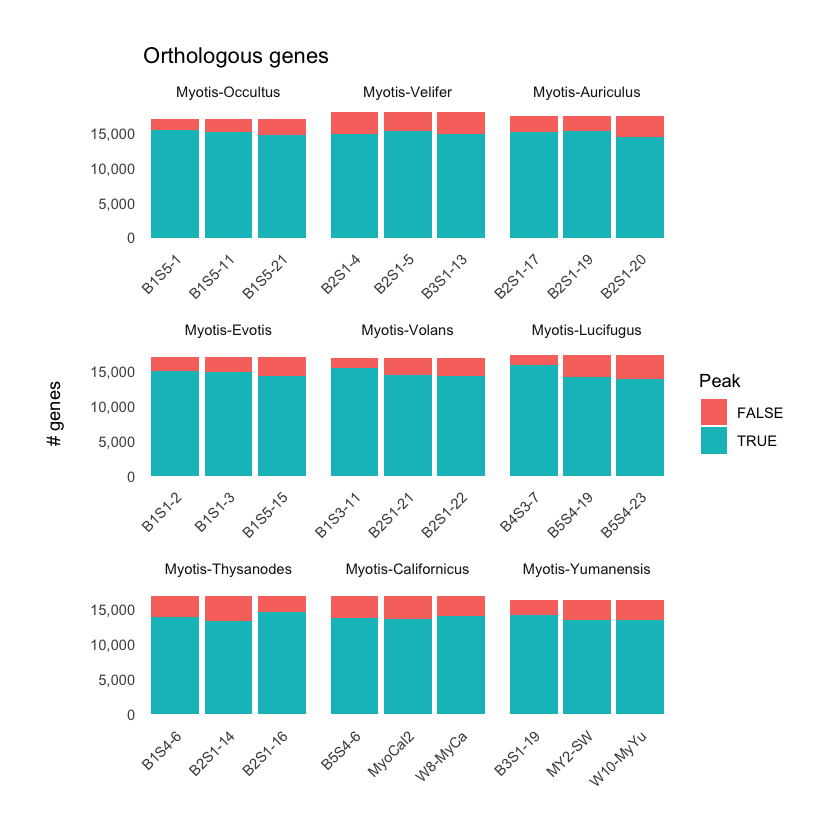

In [105]:
## Plot # of genes (with orthologs) per species:

gene_status_list <- lapply(seq_along(myo_meta$Abbr), function(i) {
  file_paths <- peak_ortho_files[grep(myo_meta$Abbr[i], peak_ortho_files)]
  indv_list <- lapply(seq_along(file_paths), function(j) {
    indv_peak_ortho <- fread(file_paths[j], data.table = FALSE)
    indv_id <- sapply(strsplit(file_paths[j], "_"), "[", 2)
    df <- indv_peak_ortho %>%
      dplyr::filter(Myotis_Alias != "") %>%
      dplyr::group_by(Myotis_Alias) %>%
      dplyr::reframe(Peak = paste(unique(Peak), collapse = ", ")) %>%
      dplyr::mutate(
        Peak = ifelse(grepl(",", Peak), TRUE, Peak),
        Species = myo_meta$Field_Name[i],
        Individual = indv_id
      )
    return(df)
  })
  return(do.call(rbind, indv_list))
})
df <- do.call(rbind, gene_status_list)

df <- df %>%
  dplyr::group_by(Species, Individual, Peak) %>%
  dplyr::reframe(
    No.Genes = n()
  )
  
x_order <- df %>%
  dplyr::filter(Peak == TRUE) %>%
  dplyr::group_by(Species) %>%
  dplyr::reframe(n = sum(No.Genes)) %>%
  dplyr::arrange(desc(n))
  
df$Species <- factor(df$Species, levels = x_order$Species)

pdf(file = paste0("results/figures/gene_peak_status_barplot.pdf"), width = 9, height = 9)

print(
  ggplot(df, aes(x = Individual, y = No.Genes, fill = Peak)) +
    geom_bar(stat = "identity") +
    theme_minimal() +
    theme(axis.title.x = element_blank(),
          axis.text.x = element_text(angle = 45, hjust = 1),
          axis.title.y = element_text(margin = margin(r = 15)),
          panel.grid = element_blank(),
          plot.margin = unit(c(1, 1, 1, 1), "cm")) +
    labs(title = "Orthologous genes") +
    xlab("Individual") + ylab("# genes") +
    scale_y_continuous(labels = comma) +
    facet_wrap(. ~ Species, scales = "free_x")
)
  
dev.off()

In [3]:
## Get genes shared between all species:

gene_list <- lapply(seq_along(peak_ortho_files), function(i) {
  peak_ortho <- fread(peak_ortho_files[i], data.table = FALSE)
  return(unique(peak_ortho$Myotis_Alias[peak_ortho$Myotis_Alias != ""]))
})

shared_genes <- Reduce(intersect, gene_list)
length(shared_genes)

[1] 13774

In [4]:
## Get peak status of shared genes:

gene_peak_list <- lapply(seq_along(peak_ortho_files), function(i) {
  peak_ortho <- fread(peak_ortho_files[i], data.table = FALSE)
  peak_ortho <- peak_ortho %>%
    dplyr::filter(Myotis_Alias %in% shared_genes) %>%
    dplyr::group_by(Myotis_Alias) %>%
    dplyr::reframe(Peak = ifelse(
      sum(Peak) > 0, TRUE, FALSE
    ))
  return(peak_ortho)
})

names(gene_peak_list) <- sapply(strsplit(sapply(strsplit(peak_ortho_files, "/"), "[", 3), "_"), function(x) paste(x[1:2], collapse = " "))
                                                                                   
# spec_peak_status <- as.data.frame.matrix(table(stack(gene_peak_list)))

spec_peak_status <- suppressMessages(suppressWarnings(
  dcast(melt(gene_peak_list), Myotis_Alias ~ L1, value.var = "Peak")
))
rownames(spec_peak_status) <- spec_peak_status$Myotis_Alias
spec_peak_status <- apply(spec_peak_status[,-1], 1, as.numeric)
spec_peak_status <- t(spec_peak_status)
colnames(spec_peak_status) <- sapply(strsplit(sapply(strsplit(peak_ortho_files, "/"), "[", 3), "_"), function(x) paste(x[1:2], collapse = " "))

In [5]:
## Restrict to variable genes:

spec_peak_status <- spec_peak_status[apply(spec_peak_status, 1, var) > 0,]

In [ ]:
## Plot species peak status:

library(RColorBrewer)
library(ComplexHeatmap)

cor_mat <- cor(spec_peak_status)
diag(cor_mat) <- NA

n_genes <- nrow(spec_peak_status)
plot_title <- paste("Peak status over", comma(n_genes), "variable shared orthologous genes")

meta_df <- data.frame(
  Species = sapply(strsplit(colnames(cor_mat), " "), "[", 1),
  row.names = colnames(cor_mat)
)
                                                       
colors <- brewer.pal(n_distinct(meta_df$Species), "Paired")
names(colors) <- unique(meta_df$Species)
meta_cols <- list(Species = colors)
                            
col_anno <- HeatmapAnnotation(df = meta_df, col = meta_cols)
row_anno <- HeatmapAnnotation(df = meta_df, col = meta_cols, which = "row", 
                              show_legend = FALSE, show_annotation_name = FALSE) 

In [ ]:
## Plot peak status heatmap

# Note: this takes a few minuts to plot

# pdf(file = paste0("results/figures/gene_peak_status_heatmap_nonzero_var.pdf"), width = 9, height = 9)

# draw(
#   ComplexHeatmap::Heatmap(name = "Peak status", 
#                           column_title = plot_title,
#                           matrix = spec_peak_status, 
#                           clustering_method_rows = "average",
#                           clustering_method_columns = "average",
#                           show_row_names = FALSE,
#                           top_annotation = col_anno),
#   padding = unit(c(1, 1, 1, 1), "cm")
# )

# dev.off()

In [148]:
## Plot peak status correlation heatmap

pdf(file = paste0("results/figures/gene_peak_status_correlation_heatmap_nonzero_var.pdf"), width = 12, height = 9)

draw(
  ComplexHeatmap::Heatmap(name = "Peak status correlation", 
                          column_title = plot_title,
                          matrix = cor_mat, 
                          clustering_method_rows = "average",
                          clustering_method_columns = "average",
                          top_annotation = col_anno,
                          left_annotation = row_anno),
  padding = unit(c(1, 1, 1, 1), "cm")
)

dev.off()

pdf 
  2

[1] 2

clusters
   1    2    3    4 
 919 2196  676 1277 

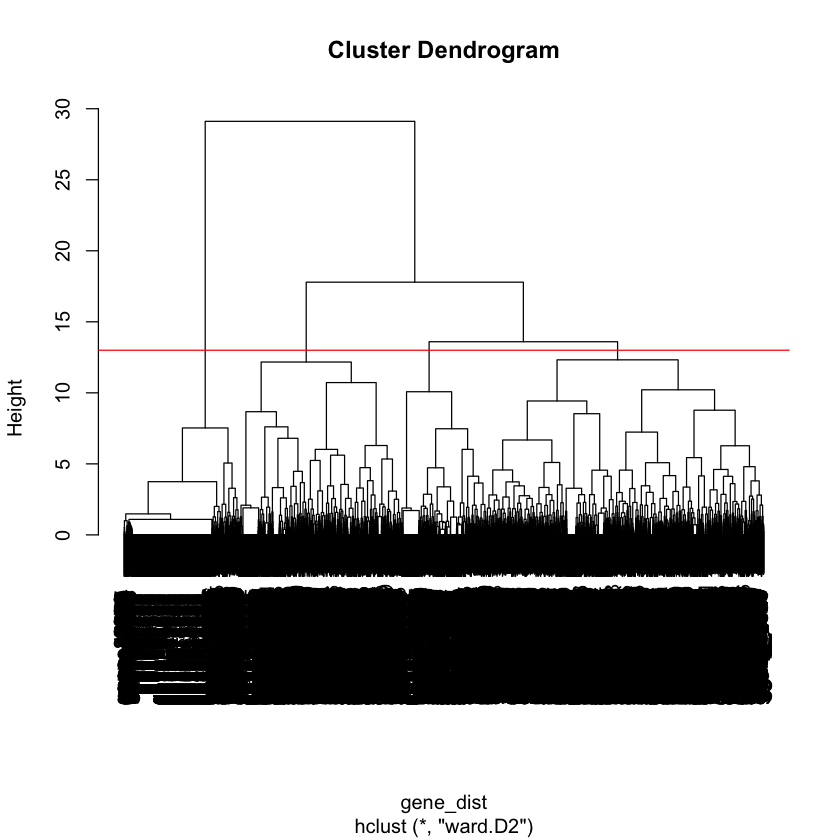

In [20]:
## Cluster genes based on peak status:

gene_dist <- as.dist(1 - cor(t(spec_peak_status))) # dist(spec_peak_status, method = "euclidean")
gene_status_dendro <- hclust(gene_dist, method = "ward.D2")

# sil_scores <- lapply(2:10, function(k) {
#   clusters <- cutree(gene_status_dendro, k = k)
#   ss <- cluster::silhouette(clusters, gene_dist)
#   return(mean(ss[,3]))
# })

# max_k <- which.max(unlist(sil_scores)) + 1
# max_k

cutheight <- 13
clusters <- cutree(gene_status_dendro, h = cutheight)
plot(gene_status_dendro)
abline(h = cutheight, col = "red")
table(clusters)

In [21]:
row_order <- order(clusters)
clusters <- clusters[row_order]
spec_peak_status <- spec_peak_status[row_order,]

In [ ]:
## Visualize clusters:

# Note: this takes a few minuts to plot

## Column annotations (species):
meta_col_df <- data.frame(
  Species = sapply(strsplit(colnames(cor_mat), " "), "[", 1),
  row.names = colnames(spec_peak_status)
)
spec_colors <- brewer.pal(n_distinct(meta_col_df$Species), "Paired")
names(spec_colors) <- unique(meta_col_df$Species)
meta_col_cols <- list(Species = spec_colors)
col_anno <- HeatmapAnnotation(df = meta_col_df, col = meta_col_cols)

## Row annotations (gene clusters):
meta_row_df <- data.frame(Cluster = clusters, 
                          row.names = rownames(spec_peak_status))
clust_colors <- brewer.pal(n_distinct(meta_row_df$Cluster), "Set2")[1:n_distinct(meta_row_df$Cluster)]
names(clust_colors) <- unique(meta_row_df$Cluster)
meta_row_cols <- list(Cluster = clust_colors)
row_anno <- HeatmapAnnotation(
  df = meta_row_df, col = meta_row_cols, which = "row",
  show_annotation_name = TRUE
) 

pdf(file = paste0("results/figures/gene_peak_status_gene_clusters_heatmap_nonzero_var.pdf"), width = 12, height = 9)

draw(
  ComplexHeatmap::Heatmap(name = "Peak status", 
                          column_title = plot_title,
                          matrix = spec_peak_status, 
                          cluster_rows = FALSE,
                          # clustering_method_rows = "average",
                          clustering_method_columns = "average",
                          show_row_names = FALSE,
                          top_annotation = col_anno,
                          right_annotation = row_anno),
   padding = unit(c(1, 1, 1, 1), "cm")
)

dev.off()

In [22]:
## What human homologs are associated with the genes in each cluster?

ortho_table <- fread("/Users/rebecca/sudmant/analyses/myotis/data/ortholog_mapping.csv", data.table = FALSE)
yum_col <- grep("^yum", colnames(ortho_table))
ortho_table[,yum_col] <- gsub("SCAF", "SUPER", ortho_table[,yum_col]) 
colnames(ortho_table)[1:3] <- c("ENSEMBL", "SYMBOL", "Myotis_Alias")

clust_alias_list <- tapply(names(clusters), clusters, "[")
clust_symbol_list <- lapply(clust_alias_list, function(cluster) {
  genes <- unique(ortho_table$SYMBOL[ortho_table$Myotis_Alias %in% cluster])  
  return(genes[!grepl("^ENS", genes)])
})

all_genes <- ortho_table$SYMBOL[ortho_table$Myotis_Alias %in% shared_genes]
all_genes <- all_genes[!grepl("^ENS", all_genes)]

In [23]:
lapply(clust_symbol_list, head, 300)

$`1`
  [1] "LASP1"      "SARM1"      "POLDIP2"    "CDC27"      "SLC4A1"    
  [6] "DVL2"       "PRSS22"     "DHX33"      "MEOX1"      "LIG3"      
 [11] "COPZ2"      "MPO"        "PDK2"       "ITGA3"      "ITGA2B"    
 [16] "OSBPL7"     "TMEM98"     "MAP3K14"    "SPATA20"    "COX10"     
 [21] "ARHGAP44"   "ELAC2"      "PAFAH1B1"   "NOS2"       "DNAH9"     
 [26] "BLTP2"      "SLC13A2"    "GAS7"       "CD79B"      "SCN4A"     
 [31] "CYB561"     "SPAG9"      "MED24"      "ZNF207"     "MRC2"      
 [36] "MKS1"       "MBTD1"      "UTP18"      "TTC19"      "BRCA1"     
 [41] "SLC25A39"   "XYLT2"      "RABEP1"     "GRN"        "ATP6V0A1"  
 [46] "MAP2K3"     "CLXN"       "TUBG2"      "CTNS"       "PHF23"     
 [51] "POLR2B"     "EPN3"       "USP36"      "CDK17"      "VMP1"      
 [56] "APPBP2"     "SEZ6"       "GSC2"       "DLX3"       "SPA17"     
 [61] "NGFR"       "GLP2R"      "MAP2K4"     "MTHFD2"     "CACNB1"    
 [66] "RHOA"       "DHX8"       "IFI35"      "HEATR6"     "COASY"     
 [71] "PLEKHH3"    "PRR11"      "SDK2"       "PFN2"       "MNT"       
 [76] "JMJD6"      "ST6GALNAC1" "WIPI1"      "EPN2"       "ALDH3A2"   
 [81] "SREBF1"     "ACADVL"     "ACAP1"      "DERL2"      "NLE1"      
 [86] "SMARCE1"    "FNDC8"      "GSDMB"      "ADAM11"     "TBX21"     
 [91] "NSF"        "NCBP3"      "BCS1L"      "SCARF1"     "ZZEF1"     
 [96] "CACNG4"     "SLC46A1"    "SPAG5"      "TNRC6C"     "STRADB"    
[101] "NFE2L1"     "ITGAE"      "PIGS"       "ATXN7L3"    "PGS1"      
[106] "PSMC5"      "METTL2A"    "GP6"        "PCBP4"      "SPG21"     
[111] "MYO15A"     "ALKBH5"     "APOH"       "PITPNM3"    "SPAG7"     
[116] "UNC13D"     "MFSD11"     "ECHDC1"     "KRT31"      "CDC6"      
[121] "DERL3"      "OSM"        "SOX10"      "RASL10A"    "SNW1"      
[126] "CTSZ"       "MYL9"       "CCL17"      "LYL1"       "ICAM5"     
[131] "CRYBA1"     "NUFIP2"     "GIT1"       "FBXL20"     "RUNDC3A"   
[136] "UBTF"       "PSMD3"      "CASC3"      "RAPGEFL1"   "RNF43"     
[141] "WNT3"       "RAD51C"     "MTMR4"      "TRIM37"     "P2RX1"     
[146] "DHX40"      "KRT37"      "TUBD1"      "GOSR2"      "PNPO"      
[151] "RPS6KB1"    "CDK5RAP3"   "CBX1"       "PIGL"       "GALK1"     
[156] "INTS2"      "CAMTA2"     "MED13"      "HOXB6"      "ENO3"      
[161] "RNF167"     "SLC25A11"   "RASD1"      "CHRNE"      "RAI1"      
[166] "NUP88"      "C1QBP"      "SLC6A4"     "BLMH"       "CPD"       
[171] "GOSR1"      "CCDC47"     "MED31"      "DRG2"       "FTSJ3"     
[176] "AKAP10"     "ALDH3A1"    "SMARCD2"    "ICAM2"      "B9D1"      
[181] "UTP6"       "C17orf75"   "PSMD11"     "LGALS3BP"   "ASIC2"     
[186] "CCL2"       "CCL1"       "PEX12"      "DHX58"      "KAT2A"     
[191] "RAB5C"      "NAGLU"      "HSD17B1"    "MLX"        "CNTNAP1"   
[196] "ABI3"       "EZH1"       "DLX4"       "PPP1R9B"    "COL1A1"    
[201] "SGCA"       "MRPL27"     "VAT1"       "LRRC59"     "ALOX12"    
[206] "HDAC5"      "ABCC3"      "LUC7L3"     "MPP2"       "SMURF2"    
[211] "DUSP3"      "CACNG1"     "EFTUD2"     "HLF"        "SLC16A6"   
[216] "PRKAR1A"    "EFNB3"      "FAM20A"     "YWHAE"      "DPH1"      
[221] "MAP2K6"     "DHRS7B"     "WSB1"       "SLC9A3R1"   "MYH3"      
[226] "TMEM104"    "VTN"        "TNFAIP1"    "IFT20"      "TMEM97"    
[231] "CDR2L"      "UNC119"     "ALDOC"      "PHF12"      "B3GAT1"    
[236] "IL23A"      "MYL2"       "HAND1"      "CFAP92"     "TFCP2L1"   
[241] "CD48"       "PCDH17"     "GNA13"      "HOXB8"      "KANSL1"    
[246] "HOXB5"      "CRHR1"      "CENPL"      "EPX"        "AKAP1"     
[251] "COIL"       "TRIM25"     "SCPEP1"     "SPOP"       "TBX2"      
[256] "SLC35B1"    "TBX4"       "TEX14"      "FAM117A"    "CXCR4"     
[261] "ATG101"     "NMI"        "KCNJ2"      "USP22"      "PIWIL1"    
[266] "SOX9"       "TEKT3"      "HS3ST3B1"   "MRPS7"      "GGA3"      
[271] "ARMC7"      "NUP85"      "SLC25A19"   "NT5C"       "MED1"      
[276] "CD93"       "KRT36"      "THRA"       "CCR7"       "NR1D1"     
[281] "STAT5A"     

In [ ]:
## Run enrichment analysis on genes in each cluster:

## Load in Broad gene sets:
gsc <- GSA.read.gmt("/Users/rebecca/sudmant/analyses/myotis/data/genesets/msigdb_v2023.2.Hs_GMTs/msigdb.v2023.2.Hs.symbols.gmt")
sets <- gsc$genesets
names(sets) <- gsc$geneset.names

In [26]:
cluster_enrichments <- lapply(clust_symbol_list, function(clust_genes) {
  clust_enrich <- sort(unlist(lapply(sets, fisher_test,
                                     mod = clust_genes,
                                     all = all_genes)))
  return(data.frame(Set = names(clust_enrich), 
                    Pval = clust_enrich,
                    Qval = qvalue(clust_enrich)$qvalues,
                    row.names = NULL))
})

In [27]:
lapply(cluster_enrichments, head, 30)

,Set,Pval,Qval
,<chr>,<dbl>,<dbl>
1,NIKOLSKY_BREAST_CANCER_17Q21_Q25_AMPLICON,1.965936e-281,6.792307e-277
2,chr17q21,7.953153e-225,1.373907e-220
3,chr17p13,1.181172e-166,1.360317e-162
4,chr17q25,1.697186e-139,1.465945e-135
5,LASTOWSKA_NEUROBLASTOMA_COPY_NUMBER_UP,9.129131e-135,6.308230e-131
6,NIKOLSKY_BREAST_CANCER_17Q11_Q21_AMPLICON,4.121397e-98,2.373238e-94
7,chr17q11,6.842041e-69,3.377036e-65
8,chr17q12,1.442916e-64,6.231592e-61
9,WP_17Q12_COPY_NUMBER_VARIATION_SYNDROME,1.168142e-63,4.484369e-60
